## Processing Sensor Data from Catalina Jemez CZO MC Pit 1
- Marc Berghouse 9/19/2020: original format
- Zach Perzan 9/23/2020: improved format and working PRISM concat

This array includes:
- apogee_SO110
- Vaisala_GMM220
- DecagonMPS2
- Decagon5TE
- Vertical Redox probes from Paleo Terra

Issues:
- I'm not sure which water potential values are unrealistic
- O2 30cm still a bit noisy

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

def plot_cols(column_list, ylabel=''):
    """Plot columns from df. Columns to plot must be in
    column_list."""
    
    n = len(column_list)

    fig, ax = plt.subplots(n, figsize=(10,3*n), tight_layout=True, sharex=True)

    for i, col in enumerate(column_list):
        ax[i].plot(df.index, df[col], label=col)
        ax[i].legend(loc='upper right')
        ax[i].set(ylabel=ylabel)
        
    return fig, ax

def remove_spikes(df, column, window=7, threshold=1):
    """Given a dataframe and column, remove values that are different 
    from the rolling median. For example, with window=5 and threshold=1000 ppm,
    values that are more than 1000 ppm off from the 5-value rolling median will
    be set to NaN.
    
    params: 
        df [dataframe]: dataframe in which the 
        column [str]: name of the column to modify within df
        window [int]: number of records over which to take the median
        threshold [float]: threshold difference above which values are 
            removed (set to NaN)
            
    returns:
        nothing (modifies data in place)
    """
    
    data = df[column].copy()
    
    rollmed = data.rolling(window).median()
    diff = (data - rollmed).abs()
    mask = diff > threshold
    data[mask] = np.nan
    
    df[column] = data

In [2]:
# Import each file individually as a dataframe and append it to a list of dataframes

infiles = ["../../raw_data/Catalina-Jemez/MC_Pit1/mc_pit1_2010.csv", 
           "../../raw_data/Catalina-Jemez/MC_Pit1/mc_pit1_2011.csv", 
           "../../raw_data/Catalina-Jemez/MC_Pit1/mc_pit1_2012.csv", 
           "../../raw_data/Catalina-Jemez/MC_Pit1/mc_pit1_2013.csv", 
           "../../raw_data/Catalina-Jemez/MC_Pit1/mc_pit1_2014.csv", 
           "../../raw_data/Catalina-Jemez/MC_Pit1/mc_pit1_2015.csv", 
           "../../raw_data/Catalina-Jemez/MC_Pit1/mc_pit1_2016.csv", 
           "../../raw_data/Catalina-Jemez/MC_Pit1/mc_pit1_2018.csv",
           "../../raw_data/Catalina-Jemez/MC_Pit1/MC1co2o2_2013.csv",  
           "../../raw_data/Catalina-Jemez/MC_Pit1/MC1co2o2_2014.csv",  
           "../../raw_data/Catalina-Jemez/MC_Pit1/MC1co2o2_2015.csv",  
           "../../raw_data/Catalina-Jemez/MC_Pit1/MC1co2o2_2016.csv",  
           "../../raw_data/Catalina-Jemez/MC_Pit1/MC1co2o2_2017.csv",  
           "../../raw_data/Catalina-Jemez/MC_Pit1/Redox_MC_Pit1_2015.csv", 
           "../../raw_data/Catalina-Jemez/MC_Pit1/Redox_MC_Pit1_2016.csv", 
           "../../raw_data/Catalina-Jemez/MC_Pit1/Redox_MC_Pit1_2017.csv", 
           "../../raw_data/Catalina-Jemez/MC_Pit1/Redox_MC_Pit1_2018.csv"]

# Lists of all dataframes
df_list = []

for infile in tqdm(infiles):
    df = pd.read_csv(infile, na_values=['NAN', -9999],  parse_dates=[0], 
                     index_col=0, skiprows=[1]) # skiprows=[1] skips the 1th row (0-indexed)
    df_list.append(df)
    
prism_path = "../../raw_data/Catalina-Jemez/Catalina-Jemez_MC_PRISM.csv"
ppt = pd.read_csv(prism_path, na_values=['NAN',-9999,-99999], skiprows=11, 
                  parse_dates=[0], index_col=0, names=['PRISM_precip.mm']) 
ppt['PRISM_precip.mm'] = pd.to_numeric(ppt['PRISM_precip.mm'])

In [3]:
columns=['SoilMoisture_12cm.m3m3', 'Decagon5TETemp_12cm.deg.C', 'BulkEC_12cm.dS/m',
            'SoilMoisture_37cm.m3m3', 'Decagon5TETemp_37cm.deg.C', 'BulkEC_37cm.dS/m',
            'SoilMoisture_57cm.m3m3', 'Decagon5TETemp_57cm.deg.C', 'BulkEC_57cm.dS/m',
            'Voltage_12cm.mV', 'Voltage_23cm.mV', 'ApogeeTemp_2cm.deg.C','ApogeeTemp_10cm.deg.C',
            'ApogeeTemp_30cm.deg.C', 'ApogeeTemp_60cm.deg.C', 'O2_2cm.percent.0-100', 
            'O2_10cm.percent.0-100', 'O2_30cm.percent.0-100', 'O2_60cm.percent.0-100',
            'CO2_2cm.ppm', 'CO2_10cm.ppm', 'CO2_30cm.ppm', 'CO2_60cm.ppm', 
            'ReductionPotential_5cm.mV','ReductionPotential_10cm.mV','ReductionPotential_30cm.mV',
            'ReductionPotential_60cm.mV',]

# Concatenate all individual files to a single dataframe
df = pd.concat(df_list)
df.columns = columns

# Resample everything to hourly averages since certain 
# sensors are measured on different schedules
df.sort_index(inplace=True) # Sort first
df = df.resample('1H').mean()
df
# Add on up-sampled PRISM data
# (resample daily to hourly, using the nearest value, then
#  add on as new column to df)
hourly_ppt = ppt.resample('1H').nearest()
df.loc[hourly_ppt.index, 'PRISM_precip.mm'] = hourly_ppt['PRISM_precip.mm']

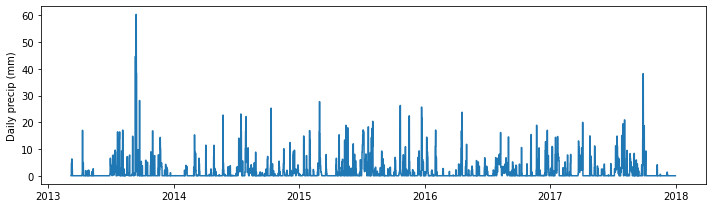

In [4]:
# Plot precip data
fig, ax = plt.subplots(figsize=(10,3), tight_layout=True)

ax.plot(df.index, df['PRISM_precip.mm'])
ax.set(ylabel='Daily precip (mm)');

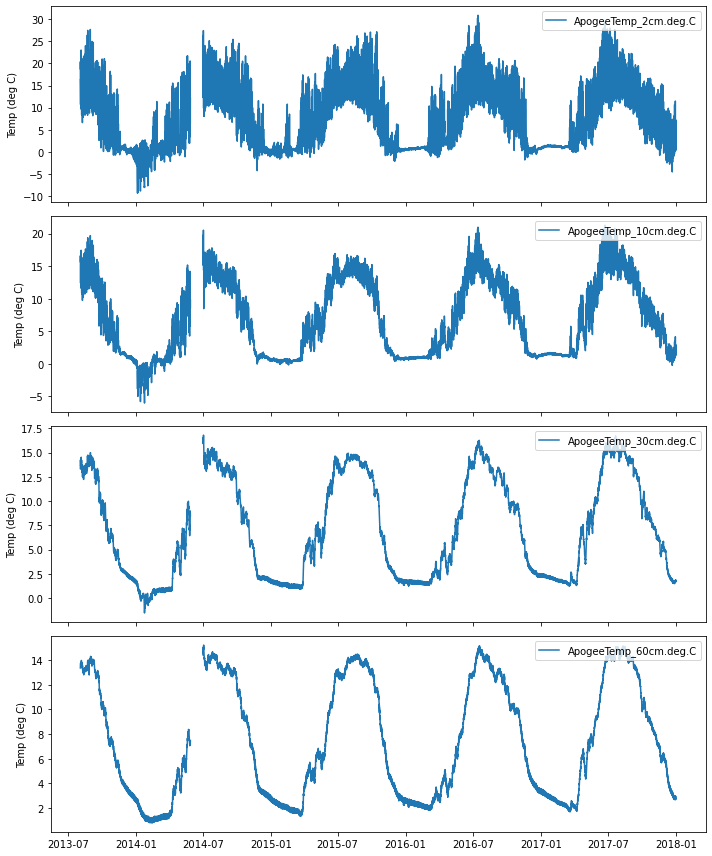

In [5]:
# Plot apogee thermistor temperature
apogee_temp_cols = [col for col in df.columns if 'ApogeeTemp' in col]
plot_cols(apogee_temp_cols, ylabel='Temp (deg C)');

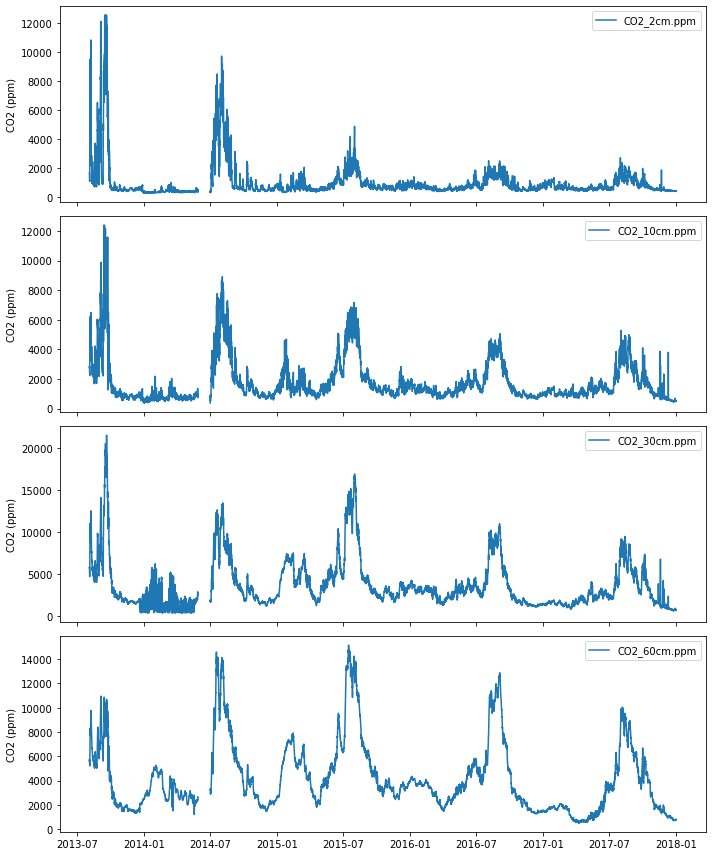

In [6]:
# Plot CO2 data
co2_cols = [col for col in df.columns if 'CO2' in col]
plot_cols(co2_cols, ylabel='CO2 (ppm)');

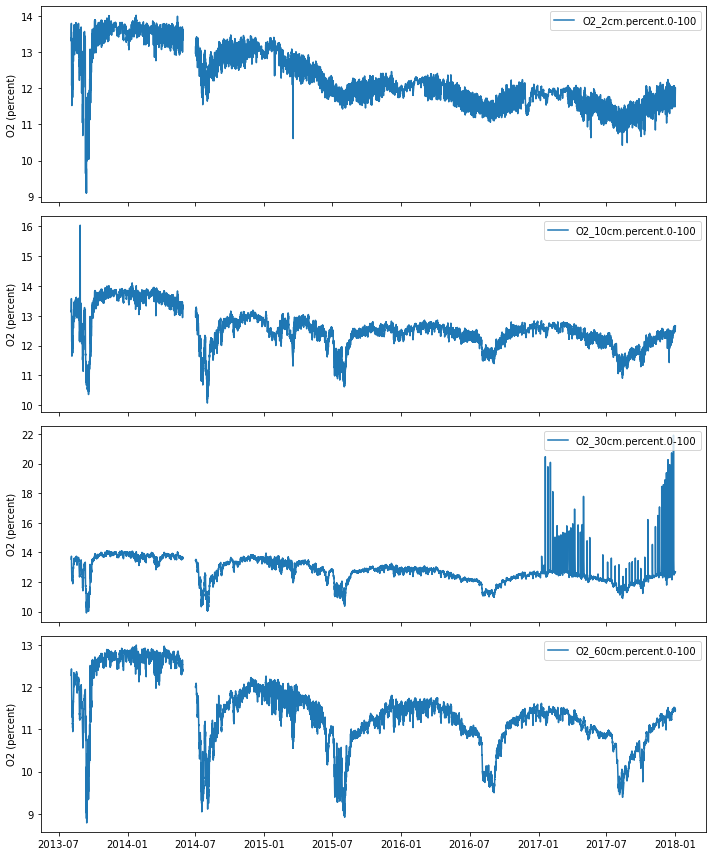

In [7]:
o2_cols = [col for col in df.columns if col[:2] == 'O2']
plot_cols(o2_cols, ylabel='O2 (percent)');

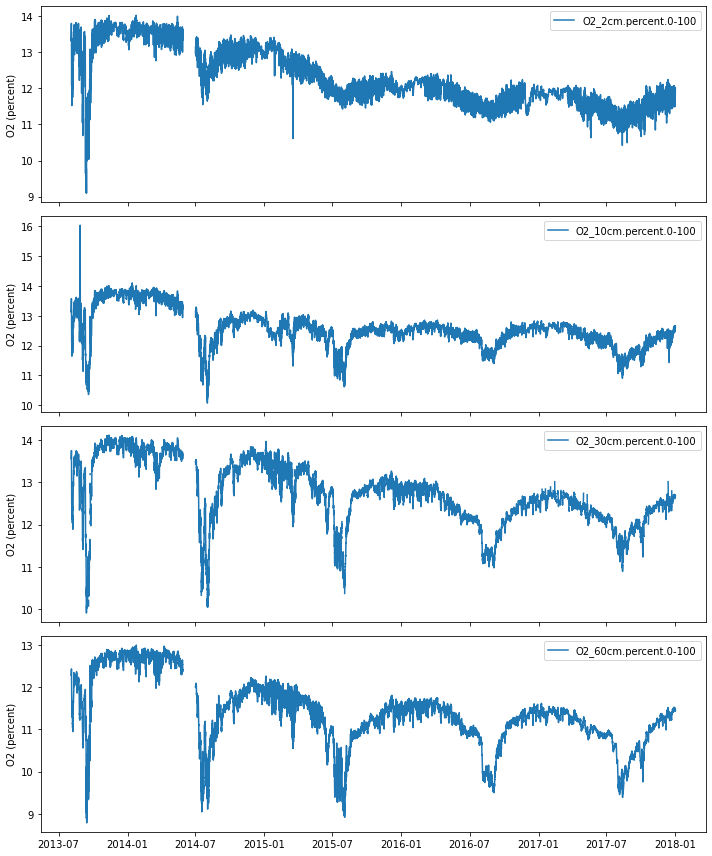

In [8]:
# Plot O2 data
remove_spikes(df, 'O2_30cm.percent.0-100', window=2, threshold=.1)

## Remove tricky 2017 voltage spikes for 30 cm
# These tend to occur in 2017, when there are NaN values followed by a jump by <0.5%,
# then a slow decrease back to baseline over the following 24 hr
sub_df = df.loc['2017-01-01':, :].copy() # copy 2017 to new df
raw = sub_df['O2_30cm.percent.0-100'].values # extract np values
raw = raw[~np.isnan(raw)] # remove NaN
mask = np.zeros(raw.shape, dtype=bool) 
mask[1:] = (raw[:-1] - raw[1:]) < -0.3 # create mask where 1-hr increase > 0.4%
spike_vals = raw[mask] # extract the first values following a spike (e.g. 13.7035%)

for i in range(len(spike_vals)):
    # In some cases, the "spike value" my occur more than once in the "raw" array
    # To limit removing extraneous data, just leave the spike in if that's the case
    if len(raw[raw == spike_vals[i]]) == 1:
        date = sub_df[sub_df['O2_30cm.percent.0-100'] == spike_vals[i]].index[0]
        
        # Delete from the moment of the spike for the following 24 hrs
        df.loc[date:date + pd.Timedelta('24h'), 'O2_30cm.percent.0-100'] = np.nan

        
o2_cols = [col for col in df.columns if col[:2] == 'O2']
fig, ax = plot_cols(o2_cols, ylabel='O2 (percent)')

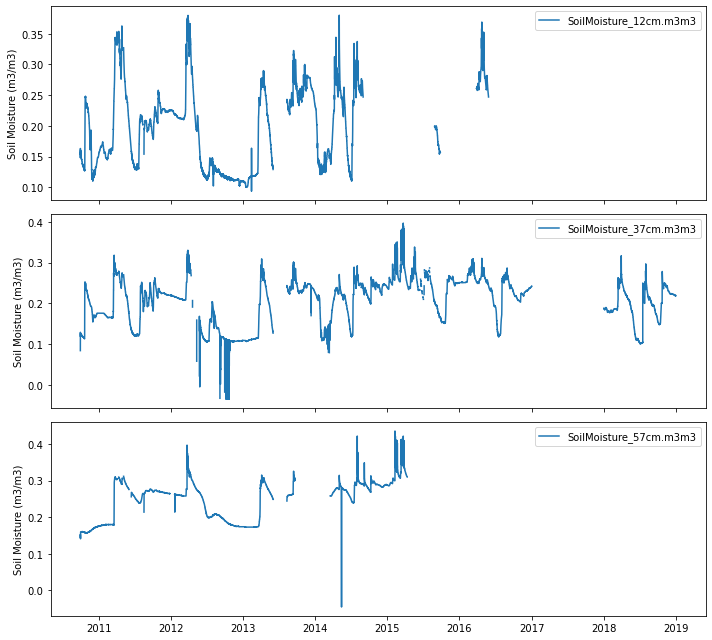

In [9]:
# Plot soil moisture data
sm_cols = [col for col in df.columns if 'SoilMoisture' in col]
fig, ax = plot_cols(sm_cols, ylabel='Soil Moisture (m3/m3)')

In [10]:
df['SoilMoisture_12cm.m3m3']=df['SoilMoisture_12cm.m3m3'].loc['2013-07-01':'2018-01-01']
df['SoilMoisture_37cm.m3m3']=df['SoilMoisture_37cm.m3m3'].loc['2013-07-01':'2018-01-01']
df['SoilMoisture_57cm.m3m3']=df['SoilMoisture_57cm.m3m3'].loc['2013-07-01':'2018-01-01']

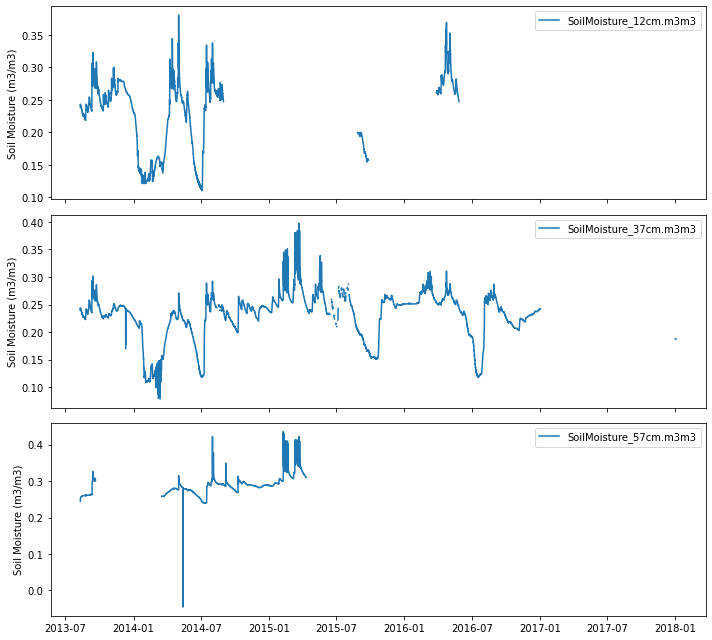

In [11]:
# Plot soil moisture data
sm_cols = [col for col in df.columns if 'SoilMoisture' in col]
plot_cols(sm_cols, ylabel='Soil Moisture (m3/m3)');

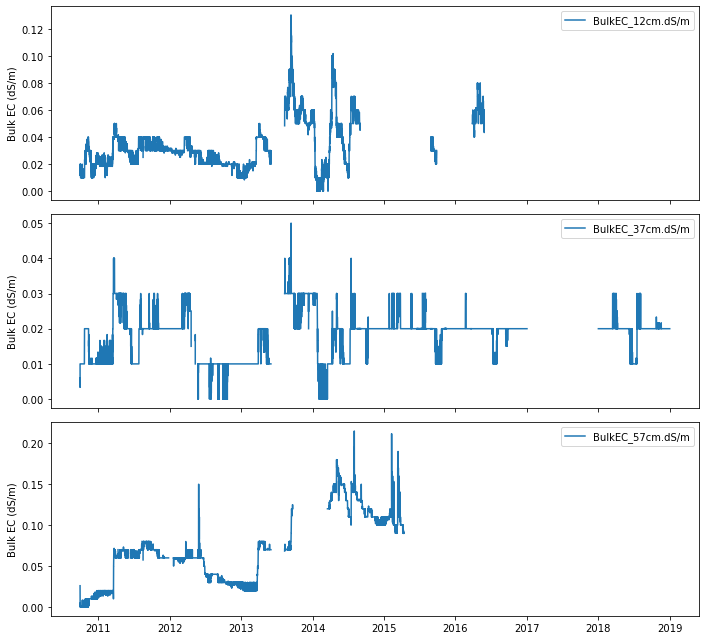

In [12]:
# Plot bulk EC
ec_cols = [col for col in df.columns if 'BulkEC' in col]
plot_cols(ec_cols, ylabel='Bulk EC (dS/m)');

In [13]:
df['BulkEC_12cm.dS/m']=df['BulkEC_12cm.dS/m'].loc['2013-07-01':'2018-01-01']
df['BulkEC_37cm.dS/m']=df['BulkEC_37cm.dS/m'].loc['2013-07-01':'2018-01-01']
df['BulkEC_57cm.dS/m']=df['BulkEC_57cm.dS/m'].loc['2013-07-01':'2018-01-01']

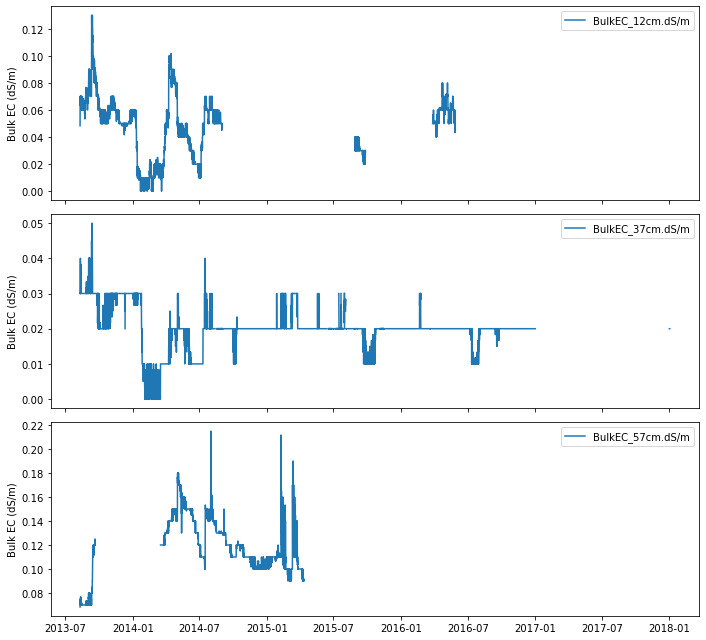

In [14]:
# Plot bulk EC
ec_cols = [col for col in df.columns if 'BulkEC' in col]
plot_cols(ec_cols, ylabel='Bulk EC (dS/m)');

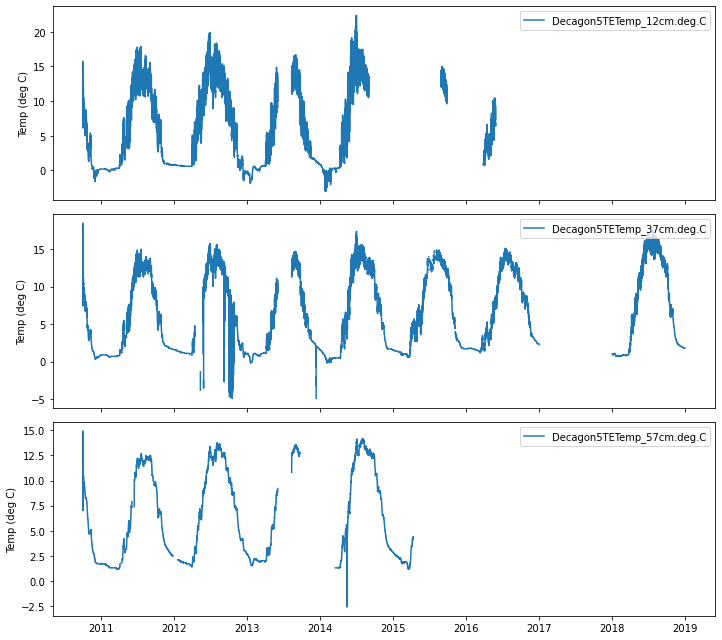

In [15]:
# Plot soil temperature from Decagon 5TE
dec_temp_cols = [col for col in df.columns if 'Decagon5TETemp' in col]

# There are several erroneous values less than -5 deg C
for col in dec_temp_cols:
    df[df[col] < -5] = np.nan
plot_cols(dec_temp_cols, ylabel='Temp (deg C)');

In [16]:
df=df.drop(columns='Decagon5TETemp_12cm.deg.C')
df=df.drop(columns='Decagon5TETemp_37cm.deg.C')
df=df.drop(columns='Decagon5TETemp_57cm.deg.C')
df=df.drop(columns='Voltage_12cm.mV')
df=df.drop(columns='Voltage_23cm.mV')

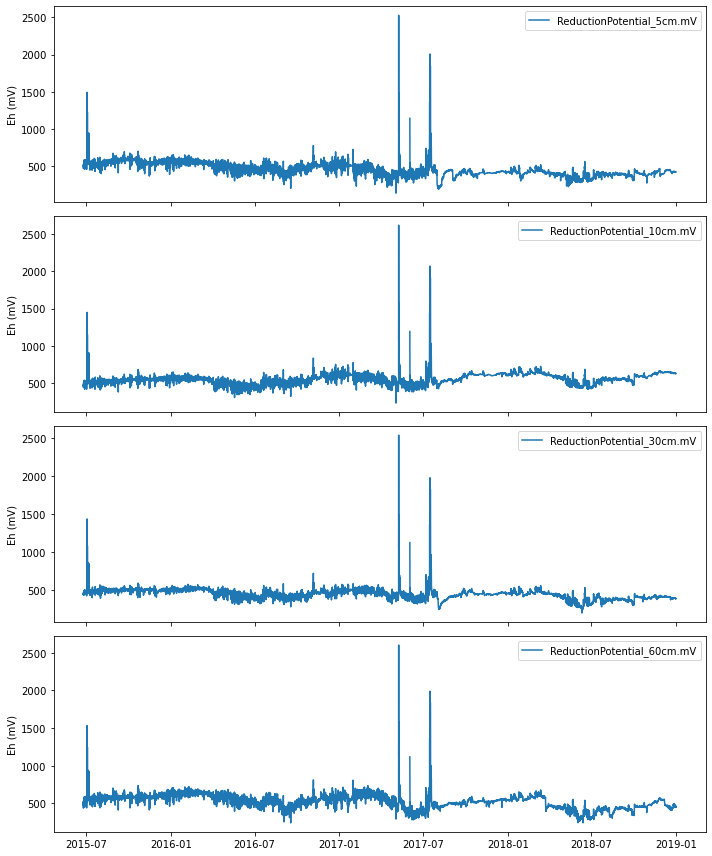

In [17]:
# Plot redox potential
eh_cols = [col for col in df.columns if 'ReductionPotential' in col]
plot_cols(eh_cols, ylabel='Eh (mV)');

In [18]:
df['ReductionPotential_5cm.mV']=df['ReductionPotential_5cm.mV'].loc['2013-07-01':'2018-01-01']
df['ReductionPotential_10cm.mV']=df['ReductionPotential_10cm.mV'].loc['2013-07-01':'2018-01-01']
df['ReductionPotential_30cm.mV']=df['ReductionPotential_30cm.mV'].loc['2013-07-01':'2018-01-01']
df['ReductionPotential_60cm.mV']=df['ReductionPotential_60cm.mV'].loc['2013-07-01':'2018-01-01']

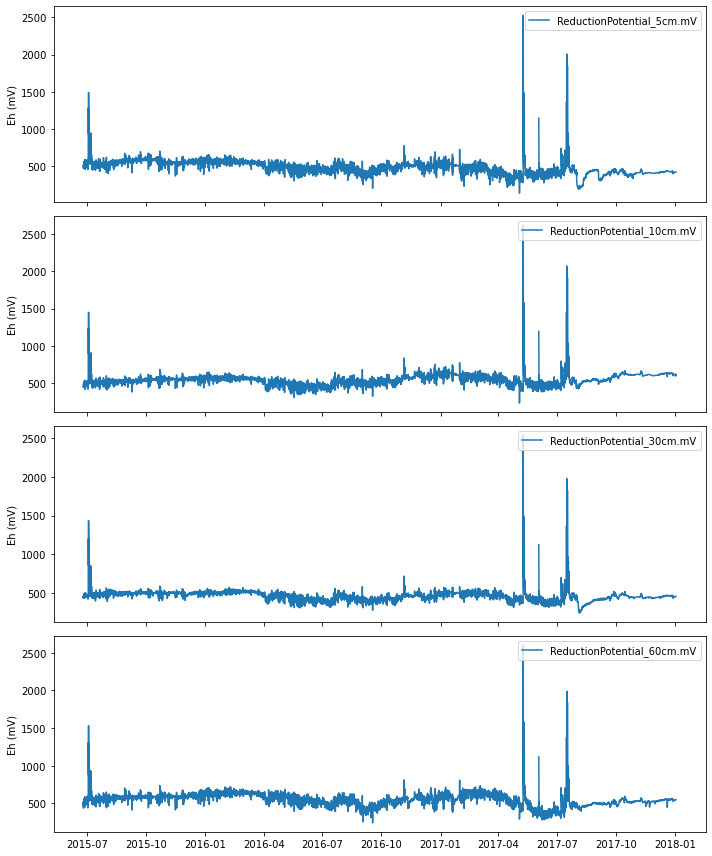

In [19]:
# Plot redox potential
eh_cols = [col for col in df.columns if 'ReductionPotential' in col]
plot_cols(eh_cols, ylabel='Eh (mV)');

In [20]:
output=df.copy()
outfile = '../../processed_data/Catalina-Jemez/MC_Pit1_processed.csv'
output.to_csv(outfile, na_rep=-99999, index_label='DateTime.MST')

In [21]:
output

,SoilMoisture_12cm.m3m3,BulkEC_12cm.dS/m,SoilMoisture_37cm.m3m3,BulkEC_37cm.dS/m,SoilMoisture_57cm.m3m3,BulkEC_57cm.dS/m,ApogeeTemp_2cm.deg.C,ApogeeTemp_10cm.deg.C,ApogeeTemp_30cm.deg.C,ApogeeTemp_60cm.deg.C,...,O2_60cm.percent.0-100,CO2_2cm.ppm,CO2_10cm.ppm,CO2_30cm.ppm,CO2_60cm.ppm,ReductionPotential_5cm.mV,ReductionPotential_10cm.mV,ReductionPotential_30cm.mV,ReductionPotential_60cm.mV,PRISM_precip.mm
2010-09-29 11:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09-29 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09-29 13:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09-29 14:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09-29 15:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-31 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-31 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-31 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
